# Book-Crossing Recommendation System

**Fellowship AI challenge**  
*Tom McKenzie*  
*July 2018*  

**Aim:** The aim of this project is to build a recommendation engine using the dataset(s) from **Book-Crossing**, which includes user reviews.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
plt.style.use('seaborn-white') # Use seaborn-style plots
plt.rcParams.update({'font.size': 20}) # Set larger default plot font size
%matplotlib inline

## Import the dataset

In [2]:
# The dataset is comprised of three separate tables: BX-Users, BX-Books, and BX-Book-Ratings.
# Each is separated by semi-colons, and the first row contains the column headers.
users = pd.read_csv('book_crossing_dataset/BX-Users.csv', sep=';')
books = pd.read_csv('book_crossing_dataset/BX-Books.csv', sep=';')
book_ratings = pd.read_csv('book_crossing_dataset/BX-Book-Ratings.csv', sep=';')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Note:** The 'BX-Books' csv had multiple cases of semi-colons in the book titles which were manually cleaned to ensure proper dataframe importing. Mostly were changed to colons or commas. Also, the symbol '&amp;' appeared a lot (presumably an ampersand character), which was changed to just '&amp'.

In [3]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
book_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
print(f'Users: {len(users)}\nBooks: {len(books)}\nRatings: {len(book_ratings)}')

Users: 278858
Books: 271379
Ratings: 1149780


## Investigate the 'users' dataframe

First, let's tidy up the column names.

In [7]:
users.columns = users.columns.str.strip().str.lower().str.replace('-', '_')
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
users.dtypes

user_id       int64
location     object
age         float64
dtype: object

In [9]:
uniq_users = users.user_id.nunique()
all_users = users.user_id.count()
print(f'No. of unique user_id entries: {uniq_users} | Total user_id entries: {all_users}')

No. of unique user_id entries: 278858 | Total user_id entries: 278858


The 'User-ID' field is integers, 'Location' are strings', and the 'Age' values are floats.

We can probably change the ages to ints. Let's take a look at the values first.

In [10]:
print(sorted(users.age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

The age range goes from 0 to 244 years old! Obviously this cannot be correct; I'll set all ages less than 5 and older than 100 to NaN to try keep them realistic.

In [11]:
users.loc[(users.age<5) | (users.age>100), 'age'] = np.nan

The Ages are also currently floats - can probably change them to ints given they are whole years only.

In [12]:
users.age.fillna(0, inplace=True)
users.age = users.age.astype(int)
users.age = users.age.replace(0, np.nan) # Change zeros back to NaNs
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Now let's have a look at the entire age range again.

In [13]:
print(sorted(users.age.unique()))

[nan, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


Much better - now the ages go from 5 to 100, with missing values entered as NaN. Let's plot this to see how they are distributed.

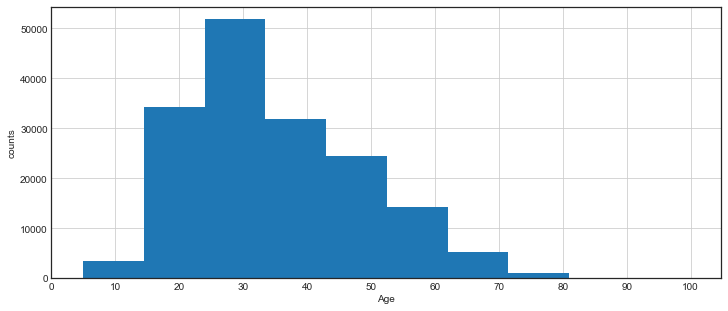

In [14]:
# First create a histogram of the Age field
ax = users.age.hist(bins=10, figsize=(12,5))
ax.set_xlabel('Age')
ax.set_ylabel('counts')
ax.set_xticks(range(0,110,10))
plt.show()

Below is the same plot without any binning - i.e. each age is represented individually.

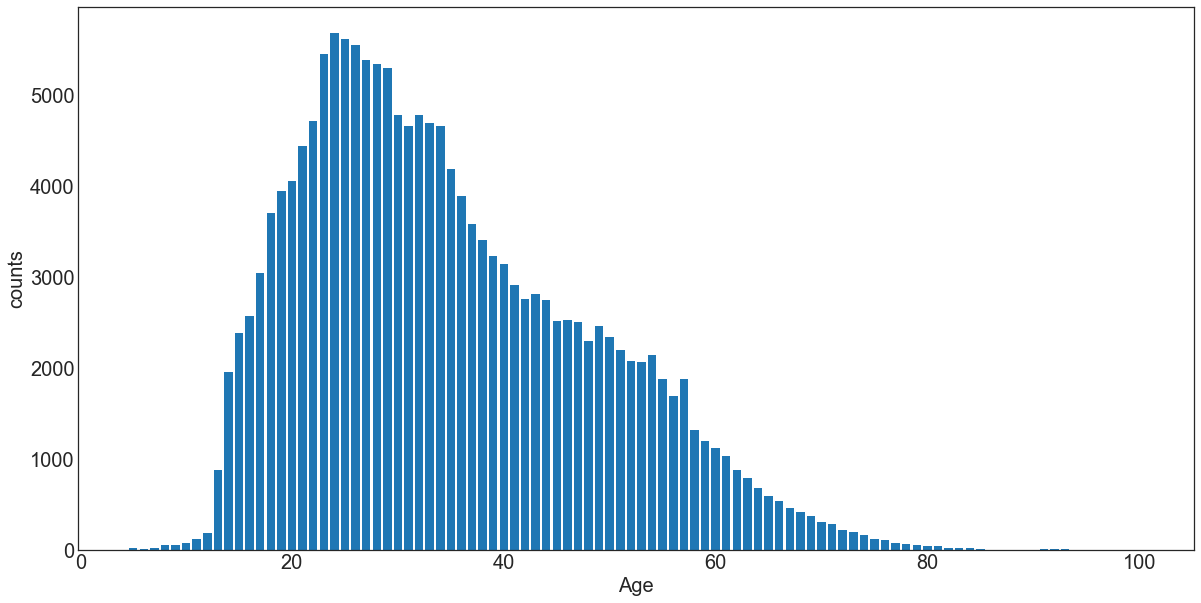

In [15]:
u = users.age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 20}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

That is more clear to me! It seems that most of our reviewers are in their late 20s to early 30s.

How many missing Age's do we now have in the dataset?

In [16]:
age_null = users.age.isnull().sum() # Sums up the 1's returned by the isnull() mask
all_users = users.user_id.count() # Counts the number of cells in the series - excludes NaNs!
print(f'There are also {age_null} empty age values in our set of {all_users} users (or {(age_null/all_users)*100:.2f}%).')

There are also 112010 empty age values in our set of 278858 users (or 40.17%).


Next, can we expand the 'Location' field to break it up into 'City', 'State', and 'Country'.

In [17]:
# Note: Used Pandas Series.str.split method as it has an 'expand' parameter which can handle None cases
user_location_expanded = users.location.str.split(',', 2, expand=True)
user_location_expanded.columns = ['city', 'state', 'country']
users = users.join(user_location_expanded)

In [18]:
users.drop(columns=['location'], inplace=True)
users.head()

,user_id,age,city,state,country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


Let's take a quick look at these Location-derived fields.

In [19]:
top_cities = users.city.value_counts()[:10]
print(f'The 10 cities with the most users are:\n{top_cities}')

The 10 cities with the most users are:
london       4105
barcelona    2664
toronto      2342
madrid       1933
sydney       1884
portland     1869
melbourne    1863
vancouver    1699
chicago      1566
seattle      1541
Name: city, dtype: int64


In [20]:
top_countries = users.country.value_counts()[:10]
print(f'The 10 countries with the most users are:\n{top_countries}')

The 10 countries with the most users are:
 usa               139183
 canada             21556
 united kingdom     18286
 germany            17021
 spain              13088
 australia          11719
 italy              11238
                     4561
 france              3440
 portugal            3305
Name: country, dtype: int64


It looks like an empty 'Country' field is in the top 10 most common entries! 

In [21]:
empty_string_country = users[users.country == ''].country.count()
nan_country = users.country.isnull().sum()
print(f'There are {empty_string_country} entries with empty strings, and {nan_country} NaN entries in the Country field')

There are 4561 entries with empty strings, and 2 NaN entries in the Country field


We should probably change these empty strings to NaNs.

In [22]:
users.country.replace('', np.nan, inplace=True)

**Might want to filter out invalid Location-based entries by looking at the city/state/country entries that only occur a few times (maybe <3), however this will be just left as is at the moment. I'll re-visit this idea more thoroughly if I end up using Location in the modeling**

## Investigate the 'books' dataframe

In [23]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


First, let's tidy up the column names. And we can probably drop the image-url link columns.

In [24]:
books.columns = books.columns.str.strip().str.lower().str.replace('-', '_') # clean column names
books.drop(columns=['image_url_s', 'image_url_m', 'image_url_l'], inplace=True) # drop image-url columns
books.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp Company


What about the 'type' of each field? We probably want Year of Publication to be ints or floats, and the rest to be strings ('object'). **Note:** The ISBN numbers may contain some letters, so we CAN'T convert them to numeric values. Will leave as strings.

In [25]:
books.dtypes

isbn                   object
book_title             object
book_author            object
year_of_publication    object
publisher              object
dtype: object

In [26]:
# Convert years to float
books.year_of_publication = pd.to_numeric(books.year_of_publication, errors='coerce')

In [27]:
# Check for 0's or NaNs in Year of Publication
zero_yr = books[books.year_of_publication == 0].year_of_publication.count()
nan_yr = books.year_of_publication.isnull().sum()
print(f'There are {zero_yr} entries as \'0\', and {nan_yr} NaN entries in the Year of Publication field')

There are 4619 entries as '0', and 3 NaN entries in the Year of Publication field


In [28]:
# Replace all years of zero with NaN
books.year_of_publication.replace(0, np.nan, inplace=True)

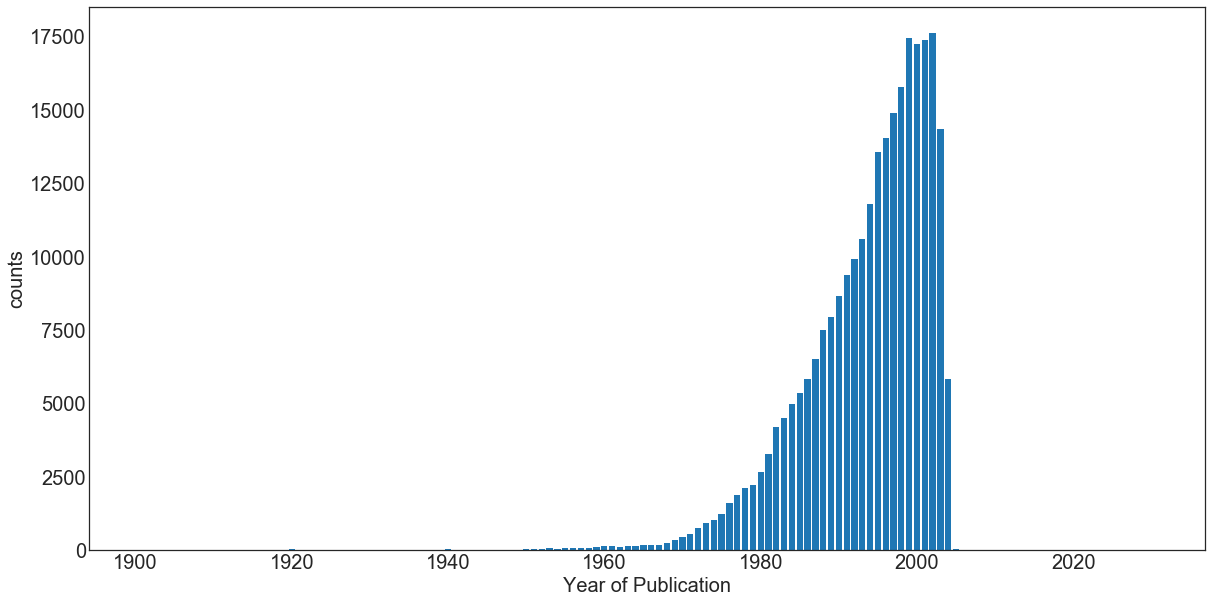

In [29]:
yr = books.year_of_publication.value_counts().sort_index()
yr = yr.where(yr>5) # filter out counts less than 5
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 20}) # Set larger plot font size
plt.bar(yr.index, yr.values)
plt.xlabel('Year of Publication')
plt.ylabel('counts')
plt.show()

Note that in the plot above we filtered out counts less than 5, as there are a few books in the dataset with publication years in the 1300s, and a few in the future (?!). The plot above show the general trend that more recent books are much more frequent.

Let's take a look at some of those 'outlier' books. Maybe we'll even keep them as a separate dataset so we can filter them out if we need to later in the analysis. We'll leave them in for now, and then figure out how to handle them once we have more info later on.

In [30]:
historical_books = books[books.year_of_publication<1900] # create df of old books
books_from_the_future = books[books.year_of_publication>2018] # create df of books with publication yrs in the future!

hist_books_mini = historical_books[['book_title', 'year_of_publication']]
future_books_mini = books_from_the_future[['book_title', 'year_of_publication']]
print(f'Historical books:\n{hist_books_mini}')
print('\n')
print(f'Future books:\n{future_books_mini}')

Historical books:
                                               book_title  year_of_publication
171826  Complete Works 10 Volumes [2,6,7,8,9] (Notable...               1806.0
227544                   Dalan-i bihisht (Dastan-i Irani)               1378.0
245622  Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...               1897.0
253767                                       Tasht-i khun               1376.0


Future books:
                                               book_title  year_of_publication
30011                                          The Royals               2020.0
37488   MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...               2030.0
55679   MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...               2030.0
78171                                    Crossing America               2030.0
80267   Alice's Adventures in Wonderland and Through t...               2050.0
92160                     Edgar Allen Poe Collected Poems               2020.0
97830       Outlin

I think we can probably omit the 'historical_books' as they may potentially skew the model and do not seem to have much relevance to the wider userbase.

Some of the 'future' books actually appear to be errors (e.g. Alice in Wonderland, Edgar Allen Poe, etc.)... Perhaps they were supposed to be e.g. 1950 instead of 2050? However, instead of investigating this further, since there are <20 books here I will simply remove them from the 'books' table.

In [31]:
print(f'Length of books dataset before removal: {len(books)}')
books = books.loc[~(books.isbn.isin(historical_books.isbn))] # remove historical books
books = books.loc[~(books.isbn.isin(books_from_the_future.isbn))] # remove historical books
print(f'Length of books dataset after removal: {len(books)}')

Length of books dataset before removal: 271379
Length of books dataset after removal: 271358


We clean up the ampersand formatting in the Publisher field.

In [32]:
books.publisher = books.publisher.str.replace('&amp', '&', regex=False)
books.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton & Company


In [33]:
uniq_books = books.isbn.nunique()
all_books = books.isbn.count()
print(f'No. of unique books: {uniq_books} | All book entries: {all_books}')

No. of unique books: 271358 | All book entries: 271358


Let's look at the most frequent Publishing houses in the dataset.

In [34]:
top_publishers = books.publisher.value_counts()[:10]
print(f'The 10 publishers with the most entries in the books table are:\n{top_publishers}')

The 10 publishers with the most entries in the books table are:
Harlequin                   7536
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3647
Scholastic                  3159
Simon & Schuster            2969
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Name: publisher, dtype: int64


What about authors with the most entries?

In [35]:
top_authors = books.book_author.value_counts()[:10]
print(f'The 10 authors with the most entries in the books table are:\n{top_authors}')

The 10 authors with the most entries in the books table are:
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        373
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: book_author, dtype: int64


We should search for empty or NaN values in these fields too.

In [36]:
empty_string_publisher = books[books.publisher == ''].publisher.count()
nan_publisher = books.publisher.isnull().sum()
print(f'There are {empty_string_publisher} entries with empty strings, and {nan_publisher} NaN entries in the Publisher field')

There are 0 entries with empty strings, and 2 NaN entries in the Publisher field


Great - no empty strings in the Publisher field, and only 2 NaNs.

In [37]:
empty_string_author = books[books.book_author == ''].book_author.count()
nan_author = books.book_author.isnull().sum()
print(f'There are {empty_string_author} entries with empty strings, and {nan_author} NaN entries in the Author field')

There are 0 entries with empty strings, and 1 NaN entries in the Author field


Cool, only 1 NaN in the Author field.

Let's look at the titles.

In [38]:
top_titles = books.book_title.value_counts()[:10]
print(f'The 10 book titles with the most entries in the books table are:\n{top_titles}')

The 10 book titles with the most entries in the books table are:
Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
The Secret Garden                 20
Dracula                           20
Adventures of Huckleberry Finn    20
Jane Eyre                         19
Pride and Prejudice               18
The Night Before Christmas        18
Great Expectations                17
Name: book_title, dtype: int64


This is actually quite an important observation. Although all of the ISBN entries are *unique* in the 'books' dataframe, different *forms* of the **same** book will have different ISBNs - i.e. paperback, e-book, etc. Therefore, we can see that some books have multiple ISBN entries (e.g. Jane Eyre has 19 different ISBNs, each corresponding to a different version of the book).

It might be more useful for our model if we simplified this to give each book a *unique* identifier, independent of the book format, as our recommendations will be for a book, not a specific version of a book.

**Will create this more unique identifier under the field name 'unique_isbn'. Note that entries with only a single ISBN number will be left the same. However, will need to do this after joining to the other tables in the dataset, as some ISBNs in the 'book-rating' table may be removed if done prior.**

## Investigate 'book_ratings' table

Again, let's tidy up the column names.

In [39]:
book_ratings.columns = book_ratings.columns.str.strip().str.lower().str.replace('-', '_')
book_ratings.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [40]:
book_ratings.dtypes

user_id         int64
isbn           object
book_rating     int64
dtype: object

The data types already look good. Remember that the ISBN numbers may contain letters, and so should be left as strings.

Which users contribute the most ratings?

In [41]:
super_users = book_ratings.groupby('user_id').isbn.count().sort_values(ascending=False)
print(f'The 20 users with the most ratings:\n{super_users[:20]}')

The 20 users with the most ratings:
user_id
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
230522     2991
16795      2948
234623     2674
36836      2529
52584      2512
245963     2507
204864     2504
55492      2459
185233     2448
171118     2421
Name: isbn, dtype: int64


Wow! User \#11676 has almost twice as many ratings as the next highest user! All of the top 20 users have thousands of ratings, which seems like a lot, although maybe I'm just a slow reader...

Let's see how they are distributed.

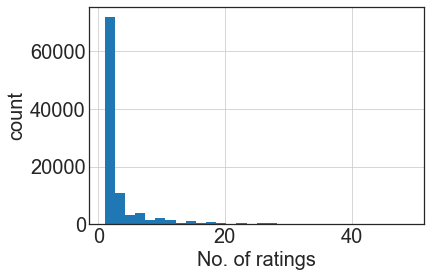

In [42]:
# user distribution - users with more than 50 ratings removed
user_hist = super_users.where(super_users<50)
user_hist.hist(bins=30)
plt.xlabel('No. of ratings')
plt.ylabel('count')
plt.show()

It looks like **_by far_** the most frequent events are users with only a single rating entry. We can see that the 'super users' with thousands of ratings are significant outliers.

This becomes clear if we make the same histogram with a cutoff for users with a minimum of 1000 ratings.

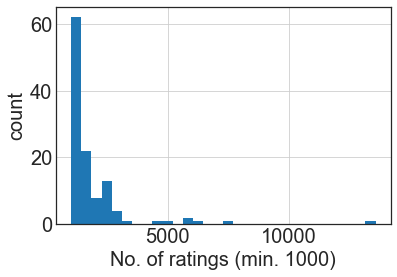

In [43]:
# only users with more than 1000 ratings
super_user_hist = super_users.where(super_users>1000)
super_user_hist.hist(bins=30)
plt.xlabel('No. of ratings (min. 1000)')
plt.ylabel('count')
plt.show()

Let's see what the distribution of ratings looks like.

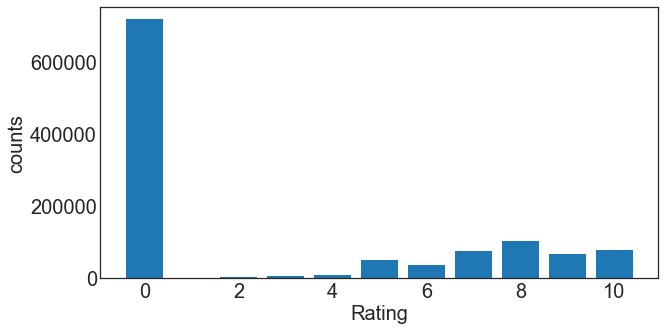

In [44]:
rtg = book_ratings.book_rating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 20}) # Set larger plot font size
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

Seems like most of the entries have a rating of zero!

After doing some research on the internet regarding this (and similar) datasets, it appears that the rating scale is actually from 1 to 10, and a 0 indicates an 'implicit' rather than an 'explicit' rating.

For the modeling step we'll only be looking at *explicit* ratings, and so the 0 rating entry rows will be removed.  
**Note:** We can change this at a later stage if implicit ratings are to be considered also.

In [45]:
print(f'Size of book_ratings before removing zero ratings: {len(book_ratings)}')
book_ratings = book_ratings[book_ratings.book_rating != 0]
print(f'Size of book_ratings after removing zero ratings: {len(book_ratings)}')

Size of book_ratings before removing zero ratings: 1149780
Size of book_ratings after removing zero ratings: 433671


By removing the implicit ratings we have reduced our sample size by more than half.

Let's look at how the ratings are distributed again.

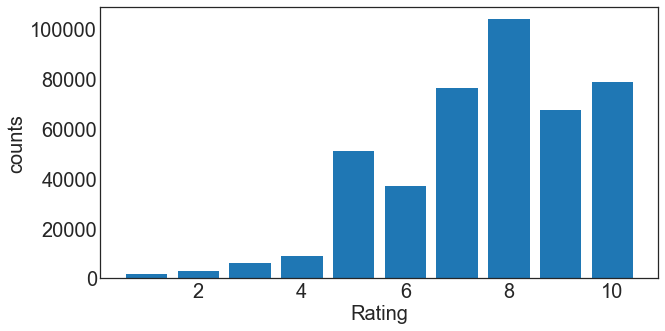

In [46]:
rtg = book_ratings.book_rating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 20}) # Set larger plot font size
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

This is much more clear! Now we can see that 8 is the most frequent rating, while users tend to give ratings > 5, with very few low ratings given.

## Unify the 'users', 'books', and 'book_ratings' tables

First, we'll join the 'books' table to the 'book_ratings' table on the ISBN field.

In [47]:
print(f'Books table size: {len(books)}')
print(f'Ratings table size: {len(book_ratings)}')
books_with_ratings = book_ratings.join(books.set_index('isbn'), on='isbn')
print(f'New table size: {len(books_with_ratings)}')

Books table size: 271358
Ratings table size: 433671
New table size: 433671


Let's take a look at the new table.

In [48]:
books_with_ratings.head()

,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press
6,276736,3257224281,8,NaN,NaN,NaN,NaN
7,276737,0600570967,6,NaN,NaN,NaN,NaN


In [49]:
print(f'There are {books_with_ratings.book_title.isnull().sum()} books with no title/author information.')
print(f'This represents {len(books_with_ratings)/books_with_ratings.book_title.isnull().sum():.2f}% of the ratings dataset.')

There are 49851 books with no title/author information.
This represents 8.70% of the ratings dataset.


There seems to be quite a few ISBNs in the ratings table that did not match an ISBN in the books table (49851 of them)!

There isn't really anything we can do about that, but we should really remove them from the dataset as we won't be able to access the title of the book to make a recommendation even if the model can use them.

In [50]:
books_with_ratings.dropna(inplace=True) # remove rows with missing title/author data

Let's see which books have the highest *cumulative* book rating values.

In [51]:
books_with_ratings.groupby('book_title').book_rating.sum().sort_values(ascending=False)[:10]

book_title
The Lovely Bones: A Novel                                           5787
The Da Vinci Code                                                   4169
The Secret Life of Bees                                             3442
The Red Tent (Bestselling Backlist)                                 3134
The Nanny Diaries: A Novel                                          2923
Harry Potter and the Chamber of Secrets (Book 2)                    2882
Bridget Jones's Diary                                               2875
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))    2815
Life of Pi                                                          2715
A Painted House                                                     2708
Name: book_rating, dtype: int64

This seems about right as it combines the total number of ratings with the score given, so these are all really popular book titles.

What about the highest average ratings (with a minimum of at least 50 ratings recieved)?

In [52]:
cutoff = books_with_ratings.book_title.value_counts()
mean_rtg = books_with_ratings[books_with_ratings.book_title.isin(cutoff[cutoff>50].index)].groupby('book_title')['book_rating'].mean()
mean_rtg.sort_values(ascending=False)[:20] # show only top 20

book_title
The Two Towers (The Lord of the Rings, Part 2)                                      9.330882
The Return of the King (The Lord of the Rings, Part 3)                              9.213592
Harry Potter and the Goblet of Fire (Book 4)                                        9.125506
The Little Prince                                                                   9.111111
Charlotte's Web (Trophy Newbery)                                                    9.073529
Harry Potter and the Sorcerer's Stone (Book 1)                                      9.062500
Harry Potter and the Order of the Phoenix (Book 5)                                  9.047393
Harry Potter and the Prisoner of Azkaban (Book 3)                                   9.043321
To Kill a Mockingbird                                                               8.977528
Dune (Remembering Tomorrow)                                                         8.973333
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperb

This looks perfectly reasonable. The Harry Potter and Lord of the Rings books rate extremely highly, as expected.

How about the lowest-rated books?

In [53]:
mean_rtg.sort_values(ascending=True)[:10] # bottom 10 only

book_title
Wild Animus                                               4.390706
Four Blondes                                              5.393939
Isle of Dogs                                              5.433962
4 Blondes                                                 5.653846
Songs in Ordinary Time (Oprah's Book Club (Paperback))    6.530303
Full Tilt (Janet Evanovich's Full Series)                 6.568627
Bleachers                                                 6.583333
Hornet's Nest                                             6.591398
My Gal Sunday                                             6.607843
Slow Waltz in Cedar Bend                                  6.619718
Name: book_rating, dtype: float64

Seems like the *lowest average* rating in the dataset is only a 4.39 - and all the rest of the books have average ratings higher than 5.

I haven't heard of any of these books, so I can't really comment on if they seem correct here.

**Now I'd like to tackle the challenge of the same book potentially having multiple ISBN numbers (for the different formats it is available in). We should clean that up here before we add the 'user' table.**

## Restrict books to a "single ISBN per book" (regardless of format)

In [54]:
multiple_isbns = books_with_ratings.groupby('book_title').isbn.count()
multiple_isbns.value_counts()[:20]

1     86753
2     20328
3      8295
4      4476
5      2852
6      1853
7      1367
8      1033
9       789
10      658
11      501
12      446
13      361
15      283
14      279
16      226
17      207
19      185
18      171
20      141
Name: isbn, dtype: int64

We can see that the vast majority of books have less than 3 associated ISBN numbers, however quite a few multiple ISBNs. We want to create a UNIQUE_ISBN such that a single book will only have 1 identifier when fed to the recommendation model.

In [55]:
has_mult_isbns = multiple_isbns.where(multiple_isbns>1)
has_mult_isbns.dropna(inplace=True) # remove NaNs, which in this case is books with a single ISBN number

In [56]:
print(f'There are {len(has_mult_isbns)} book titles with multiple ISBN numbers which we will try to re-assign to a unique identifier')

There are 46615 book titles with multiple ISBN numbers which we will try to re-assign to a unique identifier


**Note:** Created the dictionary below and pickled it, just need to load it again.

In [58]:
# Create dictionary for books with multiple isbns
# def make_isbn_dict(df):
#     title_isbn_dict = {}
#     for title in has_mult_isbns.index:
#         isbn_series = df.loc[df.book_title==title].isbn
#         title_isbn_dict[title] = isbn_series.tolist()
#     return title_isbn_dict

# %time dict_unique_isbn = make_isbn_dict(books_with_ratings)

CPU times: user 41min 25s, sys: 10.3 s, total: 41min 36s
Wall time: 42min 7s


In [61]:
# As the loop takes a while to run (39 min on the full dataset), pickle this dict for future use
# with open('multiple_isbn_dict.pickle', 'wb') as handle:
#     pickle.dump(dict_unique_isbn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
# LOAD isbn_dict back into namespace
with open('multiple_isbn_dict.pickle', 'rb') as handle:
    multiple_isbn_dict = pickle.load(handle)

EOFError: Ran out of input

In [62]:
print(f'There are now {len(multiple_isbn_dict)} books in the ISBN dictionary that have multiple ISBN numbers')

There are now 46615 books in the ISBN dictionary that have multiple ISBN numbers


In [63]:
# Add 'unique_isbn' column to 'books_with_ratings' dataframe that includes the first ISBN if multiple ISBNS,
# or just the ISBN if only 1 ISBN present anyway.
def add_unique_isbn_col(df):
    df['unique_isbn'] = df.apply(lambda row: multiple_isbn_dict[row.book_title][0] if row.book_title in multiple_isbn_dict.keys() else row.isbn, axis=1)
    return df

%time books_with_ratings = add_unique_isbn_col(books_with_ratings)

CPU times: user 20.3 s, sys: 86.4 ms, total: 20.4 s
Wall time: 20.5 s


In [64]:
x=books_with_ratings.isbn.nunique()
y=books_with_ratings.unique_isbn.nunique()
print(f'Difference in the number of unique entries: {x-y}')

Difference in the number of unique entries: 13734


We can now eliminate the book duplicates caused by multiple ISBNs by dropping duplicates in the 'unique_isbn' column.

In [65]:
print(f'Size before removing duplicates: {len(books_with_ratings)}')
books_with_ratings = books_with_ratings.drop_duplicates(subset='unique_isbn')
print(f'Size after removing duplicates: {len(books_with_ratings)}')

Size before removing duplicates: 378032
Size after removing duplicates: 133368


Removing the duplicated books (with different ISBNs) has reduced the dataset by almost 2/3rds.

In [66]:
books_with_ratings.head()

,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher,unique_isbn
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,0155061224
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,052165615X
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,0521795028
8,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday,038550120X
16,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,0060517794


Let's now drop the original 'isbn' column and replace it with the 'unique_isbn' column.

In [67]:
books_with_ratings.drop('isbn', axis=1, inplace=True)
books_with_ratings = books_with_ratings[['user_id', 'unique_isbn', 'book_rating', 'book_title', 'book_author', 'year_of_publication', 'publisher']]
books_with_ratings.head()

,user_id,unique_isbn,book_rating,book_title,book_author,year_of_publication,publisher
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press
8,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday
16,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch


## Exploratory data analysis

In [ ]:
data.info()

In [ ]:
data.shape

In [ ]:
data.head()

### Look more closely at the ISBN numbers in each of the tables

In [ ]:
book_table_isbn_unique = set(books['ISBN'])
rating_table_isbn_unique = set(book_ratings['ISBN'])

In [ ]:
# Find the 'symmetric difference' between these two sets - i.e. the val's that are in one but not the other!
isbn_diff = book_table_isbn_unique ^ rating_table_isbn_unique
len(isbn_diff)

Ok, so is most of this difference from one of the tables?

In [ ]:
in_books_but_not_in_ratings = book_table_isbn_unique - rating_table_isbn_unique
print(f'No. of books in BOOKS table not in RATINGS: {len(in_books_but_not_in_ratings)}')

in_ratings_but_not_in_books = rating_table_isbn_unique - book_table_isbn_unique
print(f'No. of books in RATINGS table not in BOOKS: {len(in_ratings_but_not_in_books)}')

There are far more ISBN numbers in the RATINGS table that don't appear in BOOKS.... Are these mainly typos or entry errors?

# Collaborative Filtering method

Initially, I'll remove all of the other fields except 'User-ID', 'ISBN', and 'Book-Rating' as those are all we need for a basic collaborative filtering model.

In [ ]:
data3 = data2[['User-ID', 'ISBN', 'Book-Rating']] # select only user, book, and rating columns
data3.columns = ['userID', 'bookID', 'rating'] # simplify column names
data3.head()

_**Note**_: ISBN numbers are currently 13 digits long, but used to be 10. Any ISBN that isn't 10 or 13 digits long is probably an error that should be handled somehow. Any that are 9 digits long might actually be SBN numbers (pre-1970), and can be converted into ISBN's by just pre-fixing with a zero.

Different ISBN's are assigned to different formats of the same book; for example, an e-book, paperback, or hardcover or Pride & Prejudice would each have a different ISBN.

The ISBN number is actually encoded info about the 'group', 'title', and 'publisher'... but not sure if I need to extract that info for this project.

# Using sklearn

In [ ]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(data3, test_size=0.25)

In [ ]:
test_data.head()

Need to cast the ISBN to int type for the matrix-forming step below. As int doesn't have NaN's, we'll convert them to zeros, then filter out any rows with an ISBN of zero.

In [ ]:
test_data['book'] = test_data['book'].fillna(0.0).astype(int)

# If we're doing this we could just use dropna() instead
# test_data['book'] = test_data['book'].dropna().astype(int)

test_data = test_data[test_data['book'] > 0]

In [ ]:
test_data.dtypes

### Assign each unique 'User-ID' or 'ISBN' an int value starting from 1 that can be mapped back

In [ ]:
# Get int mapping for USER
u_unique = test_data.user.unique()  # create a 'set' (i.e. all unique) list of vals
test_data_user2idx = {o:i for i, o in enumerate(u_unique)}

# Get int mapping for ISBN
b_unique = test_data.book.unique()  # create a 'set' (i.e. all unique) list of vals
test_data_book2idx = {o:i for i, o in enumerate(b_unique)}

In [ ]:
test_data['u_unique'] = test_data['user'].map(test_data_user2idx)
test_data['b_unique'] = test_data['book'].map(test_data_book2idx)

test_data = test_data[['u_unique', 'b_unique', 'rating']]

### Memory-based collaborative filtering

Implementing via this [tutorial](https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html).

Memory based CF can be divided into 2 main approaches:
 - Item-Item CF: "Users who liked this item also liked..."
 - User-Item CF: "Users who are similar to you also liked..."
 
In both cases, you create a user-item matrix built from the entire dataset. We'll create a matrix for each of the training and testing sets, with the users as the rows, the books as the columns, and the rating as the value/entry. Note that this will be a very sparse matrix, as not every user will have watched every movie etc.

In [ ]:
# Create user-item matrices
n_users = test_data['u_unique'].nunique()
n_books = test_data['b_unique'].nunique()

# First, create an empty matrix of size USERS x BOOKS (this speeds up the later steps)
test_matrix = np.zeros((n_users, n_books))
# Then, add the appropriate vals to the matrix by extracting them from the df with itertuples
for entry in test_data.itertuples():
    test_matrix[entry[1], entry[2]] = entry[3] # entry[1] is the user-id, entry[2] is the book-isbn

Now the matrix is in the correct format, with the user and book entries encoded from the mapping dict created above!

### Calculating cosine similarity with the 'pairwise distances' function

To determine the similarity between users/items we'll use the 'cosine similarity' which is a common n-dimensional distance metric.

Note: since all of the rating values are positive (1-10 scale), the cosine distances will all fall between 0 and 1.

In [ ]:
test_matrix.shape

In [ ]:
# This crashed the kernel last time
test_matrix_small = test_matrix[:10, :10]

from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(test_matrix_small, metric='cosine')
item_similarity = pairwise_distances(test_matrix_small.T, metric='cosine') # .T transposes the matrix (NumPy)

# What about tring 'cosine_similarity'?
# from sklearn.metrics.pairwise import cosine_similarity

If we are looking at similarity between users we need to account for the average behaviour of that individual user. For example, one user may give all movies quite high ratings, whereas one might give all ratings between 3 and 7. These users might otherwise have quite similar preferences.

To do this, we use the users average rating as a 'weighting' factor.

If we are looking at item-based similarity we don't need to add this weighting factor.

We can incorporate this into a ```predict()``` function, like so:

In [ ]:
def predict(ratings, similarity, type='user'): # default type is 'user'
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has the same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Then can make our predictions!

In [ ]:
item_prediction = predict(test_matrix_small, item_similarity, type='item')
user_prediction = predict(test_matrix_small, user_similarity, type='user')

### Evaluation

How are we going to know if this is a good model?

We'll start by just taking the root mean squared error (RMSE) (from sklearn) of predicted values in the test_set (i.e. where we know what the answer should be!).

Since we want to compare only predicted ratings that are in the test set, we can filter out all other predictions with ```prediction[ground_truth.nonzero()]```.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

# Call on test set to get error from each approach ('user' or 'item')
print(f'User-based CF RMSE: {rmse(user_prediction, test_data_matrix)}')
print(f'Item-based CF RMSE: {rmse(item_prediction, test_data_matrix)}')

Although memory-based CF is simple to implement, they don't scale very well! (Hence why some of these steps were so computationally expensive). Moreover, they fail to address the classic 'cold-start problem' - i.e. to provide recommendations to a new user with no review/rating history. 

Conversly, model-based CF methods are scalable and can deal with higher sparsity level than memory-based models. However, they still suffer for new users ('cold-start').

## Model-based CF
Model-based CF is largely based on 'matrix factorization'. 

# Using 'surprise' library
There is a python library built especially to help build recommender systems called ```surprise```.  
It includes several common model-based algorithms including SVD, KNN, and non-negative matrix factorization!  
See [here](http://surprise.readthedocs.io/en/stable/getting_started.html#basic-usage) for details.

In [ ]:
from surprise import Reader, Dataset

In [ ]:
# First need to create a 'Reader' object to set the scale/limit of the ratings field
reader = Reader(rating_scale=(1, 10))

# Load the data into a 'Dataset' object directly from the pandas df.
# Note: The fields must be in the order: user, item, rating
data = Dataset.load_from_df(data3[['userID', 'bookID', 'rating']], reader)

In [ ]:
# Load the models and 'evaluation' method
from surprise import SVD, NMF, model_selection, accuracy

Note: SVD = Singular Value Decomposition (orthogonal factorization), NMF = Non-negative Matrix Factorization.

## SVD model

**_Using cross-validation_**

In [ ]:
# svd
model = SVD()

# Run 5-fold cross-validation and print results.
# Note: Might want to try using a train/test split instead of cv and see if there is much difference.
model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True) # use Root Mean Squared Error as metric

The SVD model gave a Mean RMSE of 1.6434 after 5-folds, with a fit time of ca. 30 s.

**_Using test-train split_**

In [ ]:
# set test set to 25%.
trainset, testset = model_selection.train_test_split(data, test_size=.25)

# Instantiate the SVD model.
model = SVD()

# Train the algorithm on the training set, and predict ratings for the test set
model.fit(trainset)
predictions = model.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

The SVD model using a 75% train-test split gave a RMSE of 1.64017.

### NMF model

In [ ]:
# nmf
model = NMF()
# Run 5-fold cross-validation and print results.
model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

The NMF model gave a mean RMSE of 2.4073, with a fit time of ca. 60 s. This is much worse than the SVD model.